This implementation is easier than the one provided by the original author!

ref: https://github.com/mrzhu-cool/pix2pix-pytorch

ref: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix


In [ ]:
# download the facade dataset:
import os

if os.path.isdir("/content/facades/") == False:
  os.system("gdown https://drive.google.com/uc?id=1GYxTh39YfF80rU8gnEtfuVebA44zb4SU") # please remind that executing unzip using os.system() won't let you see the unzip message
  os.system("unzip facades.zip")
  os.remove("facades.zip")


In [ ]:
# networks.py

import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler


def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'switchable':
        norm_layer = SwitchNorm2d
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.niter, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


# update learning rate (called once every epoch)
def update_learning_rate(scheduler, optimizer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)


def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)


def init_net(net, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net.to(gpu_id)
    init_weights(net, init_type, gain=init_gain)
    return net


def define_G(input_nc, output_nc, ngf, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)

    return init_net(net, init_type, init_gain, gpu_id)


# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=9, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.inc = Inconv(input_nc, ngf, norm_layer, use_bias)
        self.down1 = Down(ngf, ngf * 2, norm_layer, use_bias)
        self.down2 = Down(ngf * 2, ngf * 4, norm_layer, use_bias)

        model = []
        for i in range(n_blocks):
            model += [ResBlock(ngf * 4, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        self.resblocks = nn.Sequential(*model)

        self.up1 = Up(ngf * 4, ngf * 2, norm_layer, use_bias)
        self.up2 = Up(ngf * 2, ngf, norm_layer, use_bias)

        self.outc = Outconv(ngf, output_nc)

    def forward(self, input):
        out = {}
        out['in'] = self.inc(input)
        out['d1'] = self.down1(out['in'])
        out['d2'] = self.down2(out['d1'])
        out['bottle'] = self.resblocks(out['d2'])
        out['u1'] = self.up1(out['bottle'])
        out['u2'] = self.up2(out['u1'])

        return self.outc(out['u2'])


class Inconv(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Inconv, self).__init__()
        self.inconv = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, out_ch, kernel_size=7, padding=0,
                      bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.inconv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3,
                      stride=2, padding=1, bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.down(x)
        return x


# Define a Resnet block
class ResBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return nn.ReLU(True)(out)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Up, self).__init__()
        self.up = nn.Sequential(
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.Conv2d(in_ch, out_ch,
            #           kernel_size=3, stride=1,
            #           padding=1, bias=use_bias),
            nn.ConvTranspose2d(in_ch, out_ch,
                               kernel_size=3, stride=2,
                               padding=1, output_padding=1,
                               bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Outconv, self).__init__()
        self.outconv = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, out_ch, kernel_size=7, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.outconv(x)
        return x


def define_D(input_nc, ndf, netD,
             n_layers_D=3, norm='batch', use_sigmoid=False, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    elif netD == 'n_layers':
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    elif netD == 'pixel':
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % net)

    return init_net(net, init_type, init_gain, gpu_id)


# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)


class PixelDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        if use_sigmoid:
            self.net.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        return self.net(input)


class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

In [ ]:
# data.py

from os.path import join
from os import listdir
from os.path import join
import random
import numpy as np

from PIL import Image
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
#from dataset import DatasetFromFolder

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('RGB')
    img = img.resize((256, 256), Image.BICUBIC)
    return img


def save_img(image_tensor, filename):
    image_numpy = image_tensor.float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    image_numpy = image_numpy.clip(0, 255)
    image_numpy = image_numpy.astype(np.uint8)
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(filename)
    print("Image saved as {}".format(filename))

class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, direction):
        super(DatasetFromFolder, self).__init__()
        self.direction = direction
        self.a_path = join(image_dir, "a")
        self.b_path = join(image_dir, "b")
        self.image_filenames = [x for x in listdir(self.a_path) if is_image_file(x)]

        transform_list = [transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

        self.transform = transforms.Compose(transform_list)

    def __getitem__(self, index):
        a = Image.open(join(self.a_path, self.image_filenames[index])).convert('RGB')
        b = Image.open(join(self.b_path, self.image_filenames[index])).convert('RGB')
        a = a.resize((286, 286), Image.BICUBIC)
        b = b.resize((286, 286), Image.BICUBIC)
        a = transforms.ToTensor()(a)
        b = transforms.ToTensor()(b)
        w_offset = random.randint(0, max(0, 286 - 256 - 1))
        h_offset = random.randint(0, max(0, 286 - 256 - 1))

        a = a[:, h_offset:h_offset + 256, w_offset:w_offset + 256]
        b = b[:, h_offset:h_offset + 256, w_offset:w_offset + 256]

        a = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(a)
        b = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(b)

        if random.random() < 0.5:
            idx = [i for i in range(a.size(2) - 1, -1, -1)]
            idx = torch.LongTensor(idx)
            a = a.index_select(2, idx)
            b = b.index_select(2, idx)

        if self.direction == "a2b":
            return a, b
        else:
            return b, a

    def __len__(self):
        return len(self.image_filenames)

def get_training_set(root_dir, direction):
    train_dir = join(root_dir, "train")

    return DatasetFromFolder(train_dir, direction)


def get_test_set(root_dir, direction):
    test_dir = join(root_dir, "test")

    return DatasetFromFolder(test_dir, direction)

In [ ]:
from __future__ import print_function
import argparse
import os
from math import log10

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

#from networks import define_G, define_D, GANLoss, get_scheduler, update_learning_rate
#from data import get_training_set, get_test_set

# Training settings
parser = argparse.ArgumentParser(description='pix2pix-pytorch-implementation')
parser.add_argument('--dataset', type=str, default='facades', help='facades')
parser.add_argument('--batch_size', type=int, default=32, help='training batch size')
parser.add_argument('--test_batch_size', type=int, default=1, help='testing batch size')
parser.add_argument('--direction', type=str, default='b2a', help='a2b or b2a')
parser.add_argument('--input_nc', type=int, default=3, help='input image channels')
parser.add_argument('--output_nc', type=int, default=3, help='output image channels')
parser.add_argument('--ngf', type=int, default=64, help='generator filters in first conv layer')
parser.add_argument('--ndf', type=int, default=64, help='discriminator filters in first conv layer')
parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count')
parser.add_argument('--niter', type=int, default=100, help='# of iter at starting learning rate')
parser.add_argument('--niter_decay', type=int, default=100, help='# of iter to linearly decay learning rate to zero')
parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
parser.add_argument('--lr_policy', type=str, default='lambda', help='learning rate policy: lambda|step|plateau|cosine')
parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', type=bool, default = True, help='use cuda?')
parser.add_argument('--threads', type=int, default=4, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--lamb', type=int, default=100, help='weight on L1 term in objective')

#opt = parser.parse_args()

opt, unknown = parser.parse_known_args()

print(opt)

if opt.cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")


Namespace(batch_size=32, beta1=0.5, cuda=True, dataset='facades', direction='b2a', epoch_count=1, input_nc=3, lamb=100, lr=0.0002, lr_decay_iters=50, lr_policy='lambda', ndf=64, ngf=64, niter=100, niter_decay=100, output_nc=3, seed=123, test_batch_size=1, threads=4)


In [ ]:
# execute training

cudnn.benchmark = True

torch.manual_seed(opt.seed)
if opt.cuda:
    torch.cuda.manual_seed(opt.seed)

print('===> Loading datasets')
root_path = "/content/" #"dataset/"
train_set = get_training_set(root_path + opt.dataset, opt.direction)
test_set = get_test_set(root_path + opt.dataset, opt.direction)
training_data_loader = DataLoader(dataset=train_set, num_workers=opt.threads, batch_size=opt.batch_size, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.test_batch_size, shuffle=False)

device = torch.device("cuda:0" if opt.cuda else "cpu")

print('===> Building models')
net_g = define_G(opt.input_nc, opt.output_nc, opt.ngf, 'batch', False, 'normal', 0.02, gpu_id=device)
net_d = define_D(opt.input_nc + opt.output_nc, opt.ndf, 'basic', gpu_id=device)

criterionGAN = GANLoss().to(device)
criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)

highest_psnr = 0
filename_highest_psnr_checkpoint = ""

# setup optimizer
optimizer_g = optim.Adam(net_g.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizer_d = optim.Adam(net_d.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
net_g_scheduler = get_scheduler(optimizer_g, opt)
net_d_scheduler = get_scheduler(optimizer_d, opt)

for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):
    # train
    for iteration, batch in enumerate(training_data_loader, 1):
        # forward
        real_a, real_b = batch[0].to(device), batch[1].to(device)
        fake_b = net_g(real_a)

        ######################
        # (1) Update D network
        ######################

        optimizer_d.zero_grad()

        # net D's output is a single number, between 0 & 1, 0 indicates fake, 1 indicates true
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(fake_ab.detach())
        loss_d_fake = criterionGAN(pred_fake, False)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = net_d.forward(real_ab)
        loss_d_real = criterionGAN(pred_real, True)

        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5

        loss_d.backward()

        optimizer_d.step()

        ######################
        # (2) Update G network
        ######################

        optimizer_g.zero_grad()

        # First, G(A) should fake the discriminator
        # In order to fake net d, set criterionGAN to true to calculate loss between pred_fake and 1 (which indicates true)
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(fake_ab)
        loss_g_gan = criterionGAN(pred_fake, True)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * opt.lamb

        loss_g = loss_g_gan + loss_g_l1

        loss_g.backward()

        optimizer_g.step()

        print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
            epoch, iteration, len(training_data_loader), loss_d.item(), loss_g.item()))

    update_learning_rate(net_g_scheduler, optimizer_g)
    update_learning_rate(net_d_scheduler, optimizer_d)

    # test
    psnr_sum = 0
    for batch in testing_data_loader:
        input, target = batch[0].to(device), batch[1].to(device)

        prediction = net_g(input)
        mse = criterionMSE(prediction, target)
        psnr = 10 * log10(1 / mse.item())
        psnr_sum += psnr


    avg_psnr = psnr_sum / len(testing_data_loader)

    if avg_psnr > highest_psnr:
          highest_psnr = avg_psnr

    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr))



    #checkpoint
    if epoch % 50 == 0:
        if not os.path.exists("checkpoint"):
            os.mkdir("checkpoint")
        if not os.path.exists(os.path.join("checkpoint", opt.dataset)):
            os.mkdir(os.path.join("checkpoint", opt.dataset))
        net_g_model_out_path = "checkpoint/{}/netG_model_epoch_{}.pth".format(opt.dataset, epoch)
        filename_highest_psnr_checkpoint = net_g_model_out_path
        #net_d_model_out_path = "checkpoint/{}/netD_model_epoch_{}.pth".format(opt.dataset, epoch)
        torch.save(net_g, net_g_model_out_path)
        print("Checkpoint saved to {}".format("checkpoint" + opt.dataset))

    if avg_psnr >= highest_psnr:
      if not os.path.exists("checkpoint"):
        os.mkdir("checkpoint")
      if not os.path.exists(os.path.join("checkpoint", opt.dataset)):
        os.mkdir(os.path.join("checkpoint", opt.dataset))
      net_g_model_out_path_best = "checkpoint/{}/netG_model_highest_psnr_{}_epoch{}.pth".format(opt.dataset, avg_psnr, epoch)
      torch.save(net_g, net_g_model_out_path_best)
      print("Highest psnr checkpoint saved to {}".format("checkpoint" + opt.dataset))
        #torch.save(net_d, net_d_model_out_path)

print("The highest psnr is {} and the checkpoint is {}".format(avg_psnr, filename_highest_psnr_checkpoint))



===> Loading datasets
===> Building models


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


initialize network with normal
initialize network with normal
===> Epoch[1](1/13): Loss_D: 1.4113 Loss_G: 59.8471
===> Epoch[1](2/13): Loss_D: 6.5790 Loss_G: 53.0904
===> Epoch[1](3/13): Loss_D: 2.6560 Loss_G: 47.0607
===> Epoch[1](4/13): Loss_D: 1.6238 Loss_G: 42.0039
===> Epoch[1](5/13): Loss_D: 1.1363 Loss_G: 40.1902
===> Epoch[1](6/13): Loss_D: 0.9997 Loss_G: 39.6290
===> Epoch[1](7/13): Loss_D: 0.7449 Loss_G: 37.7600
===> Epoch[1](8/13): Loss_D: 0.7251 Loss_G: 36.4150
===> Epoch[1](9/13): Loss_D: 0.6154 Loss_G: 38.3103
===> Epoch[1](10/13): Loss_D: 0.6259 Loss_G: 36.6622
===> Epoch[1](11/13): Loss_D: 0.5950 Loss_G: 35.3908
===> Epoch[1](12/13): Loss_D: 0.6207 Loss_G: 35.7970
===> Epoch[1](13/13): Loss_D: 0.7643 Loss_G: 36.7855
learning rate = 0.0002000
learning rate = 0.0002000
===> Avg. PSNR: 7.2011 dB
Highest psnr checkpoint saved to checkpointfacades
===> Epoch[2](1/13): Loss_D: 0.8004 Loss_G: 38.5846
===> Epoch[2](2/13): Loss_D: 0.7043 Loss_G: 36.8291
===> Epoch[2](3/13): Loss

Namespace(cuda=False, dataset='facades', direction='b2a', nepochs=200)
Image saved as result/facades/cmp_x0060.png
Image saved as result/facades/cmp_b0148.png
Image saved as result/facades/cmp_x0220.png
Image saved as result/facades/cmp_x0033.png
Image saved as result/facades/cmp_b0285.png
Image saved as result/facades/cmp_b0239.png
Image saved as result/facades/cmp_b0271.png
Image saved as result/facades/cmp_b0345.png
Image saved as result/facades/cmp_b0306.png
Image saved as result/facades/cmp_x0147.png
Image saved as result/facades/cmp_b0275.png
Image saved as result/facades/cmp_b0355.png
Image saved as result/facades/cmp_x0070.png
Image saved as result/facades/cmp_x0083.png
Image saved as result/facades/cmp_x0224.png
Image saved as result/facades/cmp_b0157.png
Image saved as result/facades/cmp_x0197.png
Image saved as result/facades/cmp_b0353.png
Image saved as result/facades/cmp_b0305.png
Image saved as result/facades/cmp_b0363.png
Image saved as result/facades/cmp_x0142.png
Image

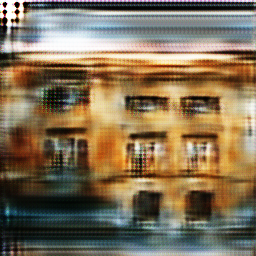

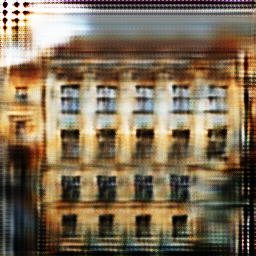

In [ ]:
# test.py

from __future__ import print_function
import argparse
import os

import torch
import torchvision.transforms as transforms

import numpy as np

import cv2
from google.colab.patches import cv2_imshow

#from utils import is_image_file, load_img, save_img

# Testing settings
parser = argparse.ArgumentParser(description='pix2pix-pytorch-implementation')
#parser.add_argument('--dataset', required=True, help='facades')
parser.add_argument('--dataset', type=str, default='facades', help='facades')
parser.add_argument('--direction', type=str, default='b2a', help='a2b or b2a')
parser.add_argument('--nepochs', type=int, default=200, help='saved model of which epochs')
parser.add_argument('--cuda', action='store_true', help='use cuda')
#opt = parser.parse_args()

opt, unknown = parser.parse_known_args()

print(opt)

device = torch.device("cuda:0" if opt.cuda else "cpu")

model_path = "checkpoint/{}/netG_model_epoch_{}.pth".format(opt.dataset, opt.nepochs)

net_g = torch.load(model_path).to(device)

if opt.direction == "a2b":
    image_dir = "/content/{}/test/a/".format(opt.dataset)
else:
    image_dir = "/content/{}/test/b/".format(opt.dataset)

image_filenames = [x for x in os.listdir(image_dir) if is_image_file(x)]

transform_list = [transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

transform = transforms.Compose(transform_list)

for image_name in image_filenames:
    img = load_img(image_dir + image_name)
    img = transform(img)
    input = img.unsqueeze(0).to(device)
    out = net_g(input)
    out_img = out.detach().squeeze(0).cpu()

    if not os.path.exists(os.path.join("result", opt.dataset)):
        os.makedirs(os.path.join("result", opt.dataset))
    save_img(out_img, "result/{}/{}".format(opt.dataset, image_name))


img1 = cv2.imread('result/facades/cmp_x0060.png')
img2 = cv2.imread('result/facades/cmp_b0148.png')

cv2_imshow(img1)
cv2_imshow(img2)